Import packages

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold

Load data

In [84]:
read_train_data = pd.read_csv('../result/all_beta_normalized_train_0.4.csv')
read_test_data = pd.read_csv('../result/all_beta_normalized_test_0.4.csv')
info_data = pd.read_csv('../result/result_basic_dbeta_0.4.csv')
X = pd.concat([read_train_data.iloc[:,1::2], read_test_data.iloc[:,1::2]], axis=1, ignore_index=True)
X = X.T
Y = pd.DataFrame([ (0 if i < 47 else 1)  for i in range(445)] + [ (0 if i < 50 else 1)  for i in range(450)])

In [85]:
print(X.shape)
print(Y.shape)

(895, 139)
(895, 1)


In [48]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
for X_item, Y_item in skf.split(X, Y):
    print(X_item.shape, Y_item.shape)

(805,) (90,)
(805,) (90,)
(805,) (90,)
(805,) (90,)
(805,) (90,)
(806,) (89,)
(806,) (89,)
(806,) (89,)
(806,) (89,)
(806,) (89,)


Here, try using nerual network to predict tumor or not

NN model

In [56]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

def train(model, train_data, train_labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        train_outputs = model(train_data)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_data)
            test_loss = criterion(test_outputs, test_labels)
            test_losses.append(test_loss.item())
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {train_loss.item()}, Test Loss = {test_loss.item()}")
    return train_losses, test_losses

In [57]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

Prepare train and test data

In [58]:
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels).float().unsqueeze(1)
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels).float().unsqueeze(1)

> When you call model.eval(), it changes the behavior of the model by disabling certain operations like dropout and batch normalization during inference. These operations are often used during training to improve generalization and prevent overfitting, but they are not needed during inference.

In [108]:
input_size = train_data.shape[1]

# hyper parameters
hidden_size = 20
num_epochs = 110
learning_rate = 0.002

model = Net(input_size, hidden_size)

train_losses, test_losses = train(model, train_data, train_labels, test_data, test_labels, num_epochs, learning_rate)

model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
NN_test_predictions = test_outputs.numpy().flatten()

Epoch 10: Train Loss = 0.15573857724666595, Test Loss = 0.13449351489543915
Epoch 20: Train Loss = 0.1494959592819214, Test Loss = 0.1400371789932251
Epoch 30: Train Loss = 0.1434277445077896, Test Loss = 0.12908686697483063
Epoch 40: Train Loss = 0.12064653635025024, Test Loss = 0.11113101989030838
Epoch 50: Train Loss = 0.11836438626050949, Test Loss = 0.11119357496500015
Epoch 60: Train Loss = 0.11557700484991074, Test Loss = 0.10787735879421234
Epoch 70: Train Loss = 0.11251736432313919, Test Loss = 0.10442011058330536
Epoch 80: Train Loss = 0.11058170348405838, Test Loss = 0.10241673141717911
Epoch 90: Train Loss = 0.10858430713415146, Test Loss = 0.10074248909950256
Epoch 100: Train Loss = 0.10691903531551361, Test Loss = 0.09926433116197586
Epoch 110: Train Loss = 0.10541613399982452, Test Loss = 0.0977558046579361


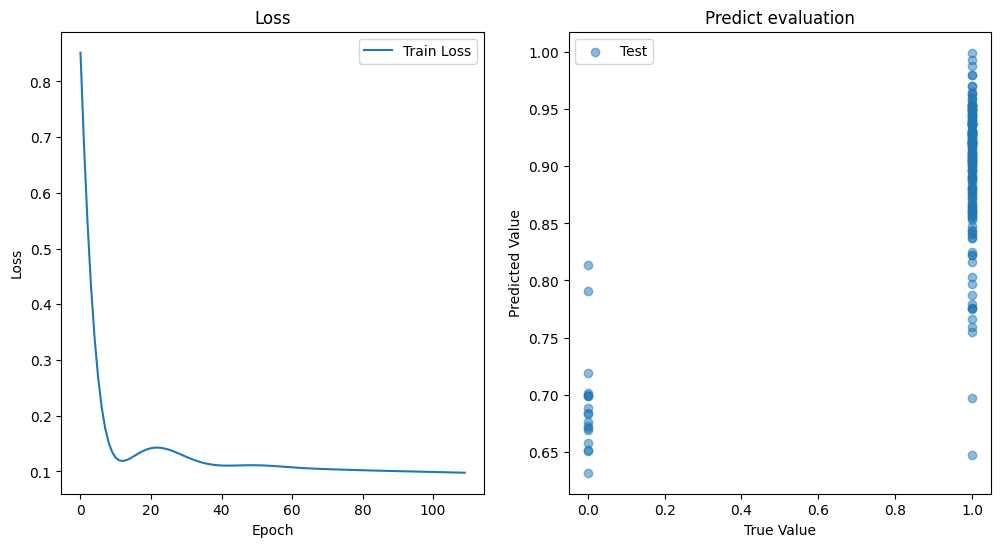

In [109]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(test_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(test_labels.numpy(), NN_test_predictions, alpha=0.5, label='Test')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('Predict evaluation')
plt.show()

try using ridge Regression to predict tumor or not

Ridge regression(l2 regularization)

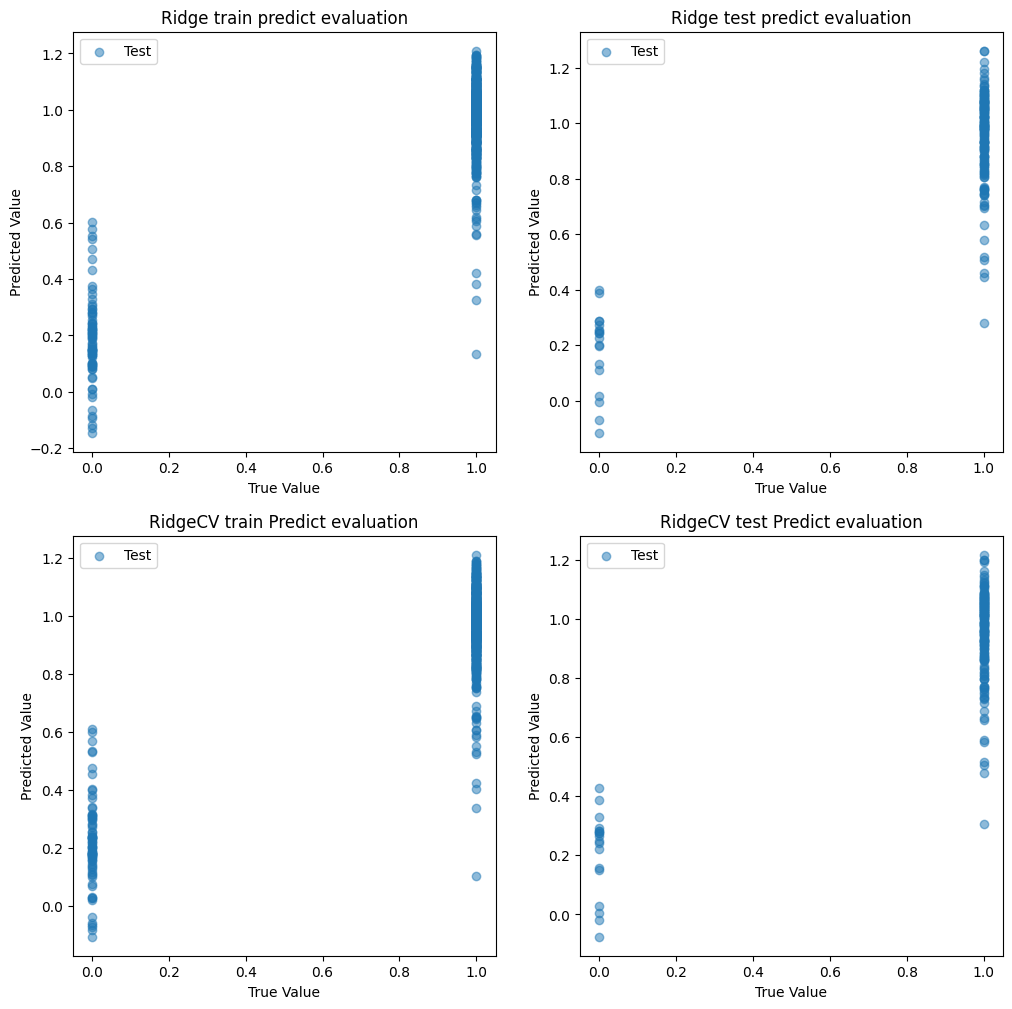

Ridge train RMSE:  0.1401639667026926
Ridge test RMSE:  0.16984402958766687
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        18
         1.0       1.00      0.98      0.99       161

    accuracy                           0.98       179
   macro avg       0.93      0.99      0.96       179
weighted avg       0.99      0.98      0.98       179

RidgeCV train RMSE:  0.14500811566142577
RidgeCV test RMSE:  0.16586583734771837
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        18
         1.0       1.00      0.99      0.99       161

    accuracy                           0.99       179
   macro avg       0.95      0.99      0.97       179
weighted avg       0.99      0.99      0.99       179



In [24]:
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.metrics import mean_squared_error

ridge = Ridge(    
    alpha=1.0
)

ridge.fit(train_data, train_labels)

Ridge_train_predictions = ridge.predict(train_data)
Ridge_test_predictions = ridge.predict(test_data)

# use RidgeCV to find the best alpha
alphas = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

ridge_cv.fit(train_data, train_labels)

RidgeCV_train_predictions = ridge_cv.predict(train_data)
RidgeCV_test_predictions = ridge_cv.predict(test_data)

plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.scatter(train_labels, Ridge_train_predictions, alpha=0.5, label='Test')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('Ridge train predict evaluation')

plt.subplot(2,2,2)
plt.scatter(test_labels, Ridge_test_predictions, alpha=0.5, label='Test')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('Ridge test predict evaluation')
plt.subplot(2,2,3)
plt.scatter(train_labels, RidgeCV_train_predictions, alpha=0.5, label='Test')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('RidgeCV train Predict evaluation')

plt.subplot(2,2,4)
plt.scatter(test_labels, RidgeCV_test_predictions, alpha=0.5, label='Test')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('RidgeCV test Predict evaluation')

plt.show()

print("Ridge train RMSE: ", np.sqrt(mean_squared_error(train_labels, Ridge_train_predictions)))
print("Ridge test RMSE: ", np.sqrt(mean_squared_error(test_labels, Ridge_test_predictions)))
print(classification_report(test_labels, np.round(Ridge_test_predictions)))
print("RidgeCV train RMSE: ", np.sqrt(mean_squared_error(train_labels, RidgeCV_train_predictions)))
print("RidgeCV test RMSE: ", np.sqrt(mean_squared_error(test_labels, RidgeCV_test_predictions)))
print(classification_report(test_labels, np.round(RidgeCV_test_predictions)))

c:\Users\Vincent\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Vincent\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Vincent\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


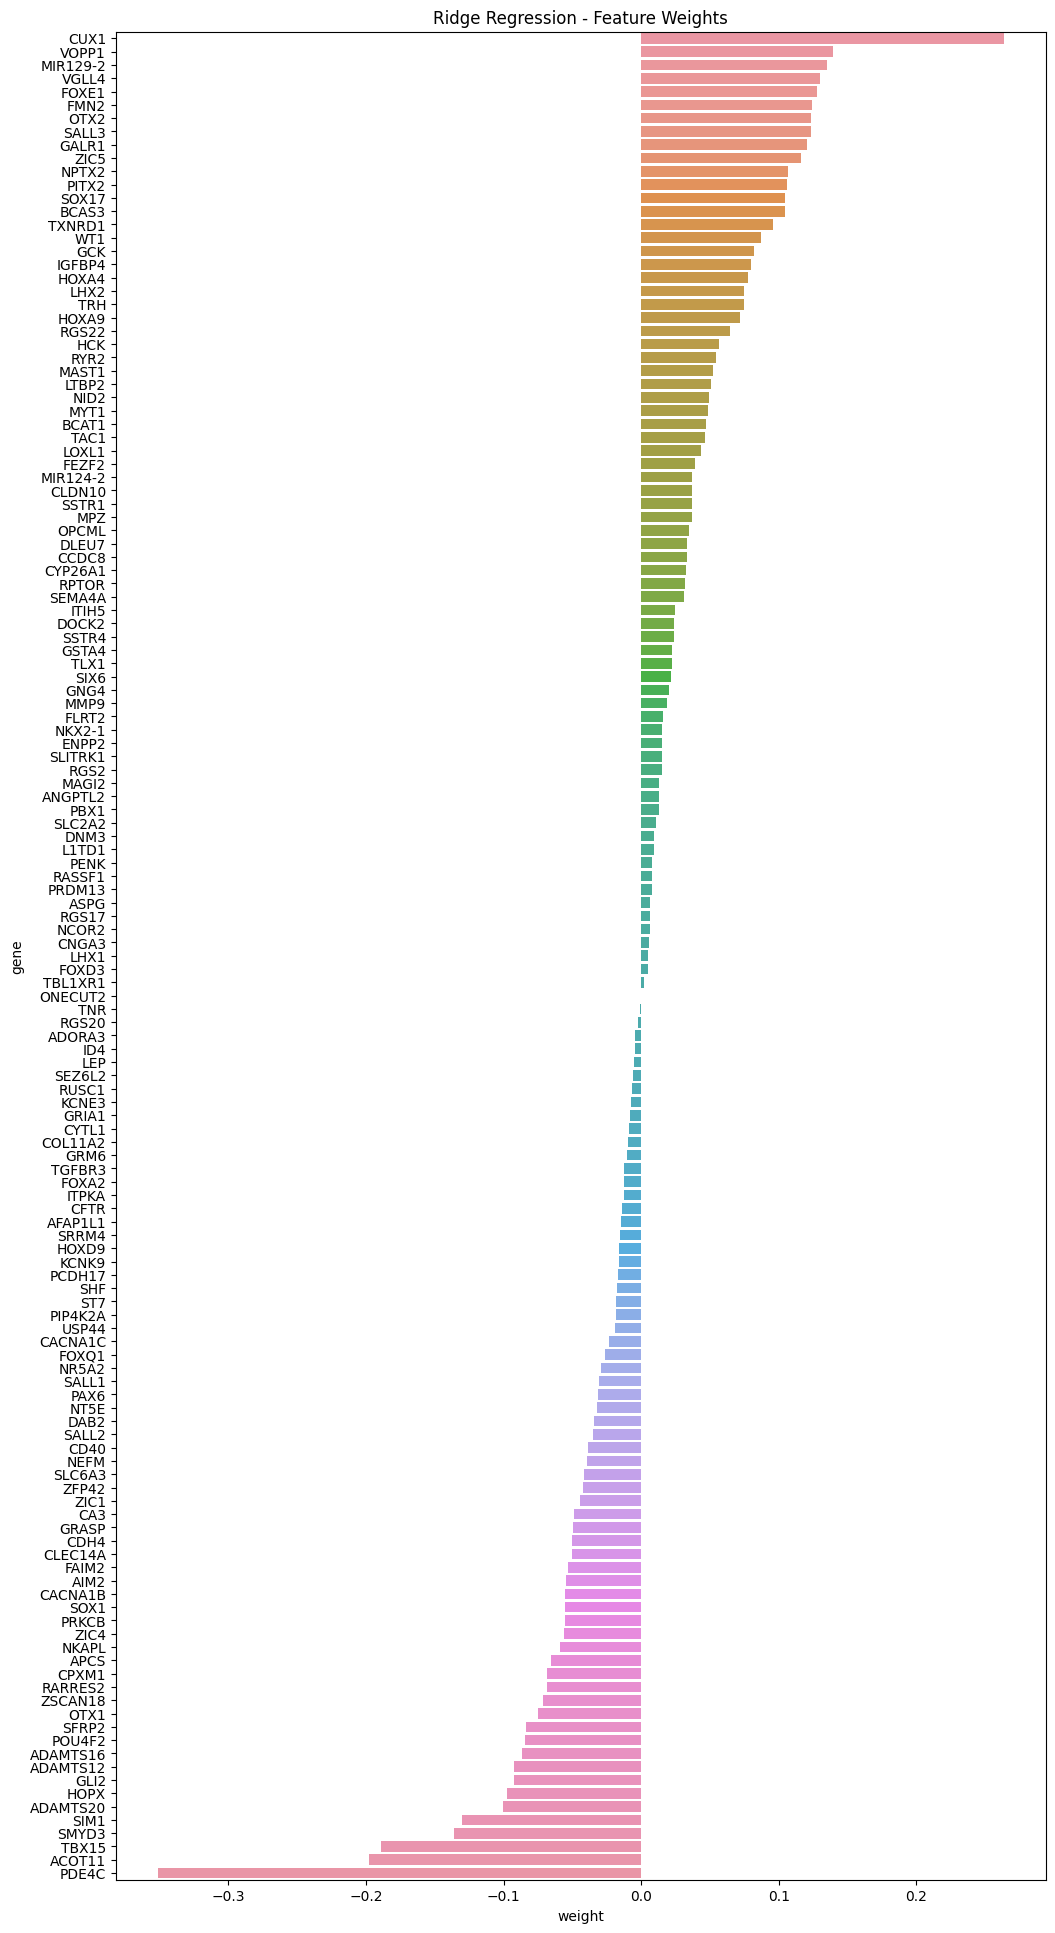

In [36]:
import seaborn as sns
feature_weights = ridge.coef_[0]
data = pd.DataFrame({'gene':info_data['gene'],'weight':feature_weights})
data.sort_values(by=['weight'],ascending=False,inplace=True)
# sns.barplot(x = feature_weights,y=info_data['gene'])
sns.barplot(x = 'weight',y='gene',data=data)
# make size larger
plt.rcParams['figure.figsize'] = [12, 36]
# set plot size
# plt.rcParams['figure.figsize'] = [6, 12]
plt.title('Ridge Regression - Feature Weights')
# plt.tight_layout()
plt.show()

Autoencoder

In [38]:
# # # Load and preprocess the MNIST dataset
# (x_train, _), (x_test, _) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [39]:
# print(x_train.shape)
# print(x_test.shape)

(60000, 784)
(10000, 784)


In [110]:
# split the data into train and test 0.8/0.2
x_train, x_test = train_test_split(X, test_size=0.2, random_state=42)

In [111]:
print(x_train.shape)
print(x_test.shape)

(716, 139)
(179, 139)


In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the architecture of the autoencoder
input_size = 139
mid_size = 80
encoding_dim = 20

class Autoencoder(nn.Module):
    def __init__(self, input_size, mid_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, mid_size),
            nn.ReLU(),
            nn.Linear(mid_size, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, mid_size),
            nn.Sigmoid(),
            nn.Linear(mid_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_size, mid_size, encoding_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Extract the encoder model
class Encoder(nn.Module):
    def __init__(self, encoder):
        super(Encoder, self).__init__()
        self.encoder = encoder

    def forward(self, x):
        x = self.encoder(x)
        return x

encoder_model = Encoder(autoencoder.encoder)

# Encode some data from the test set
encoded_imgs = encoder_model(x_test_tensor).detach().numpy()


Epoch 1, Loss: 0.6975643436113993
Epoch 2, Loss: 0.6889936923980713
Epoch 3, Loss: 0.6834498047828674
Epoch 4, Loss: 0.6793371240297953
Epoch 5, Loss: 0.6764410932858785
Epoch 6, Loss: 0.6742034157117208
Epoch 7, Loss: 0.6721101800600687
Epoch 8, Loss: 0.6701982220013937
Epoch 9, Loss: 0.6684436400731405
Epoch 10, Loss: 0.6662789781888326
Epoch 11, Loss: 0.6638781229654948
Epoch 12, Loss: 0.6605756084124247
Epoch 13, Loss: 0.6571907798449198
Epoch 14, Loss: 0.6528979738553365
Epoch 15, Loss: 0.6478697856267294
Epoch 16, Loss: 0.6424399018287659
Epoch 17, Loss: 0.6365583737691244
Epoch 18, Loss: 0.630434254805247
Epoch 19, Loss: 0.6254193782806396
Epoch 20, Loss: 0.6224959095319113
Epoch 21, Loss: 0.6191783746083578
Epoch 22, Loss: 0.617894192536672
Epoch 23, Loss: 0.6155108213424683
Epoch 24, Loss: 0.6136865417162577
Epoch 25, Loss: 0.6127620339393616
Epoch 26, Loss: 0.6118698120117188
Epoch 27, Loss: 0.6114074985186259
Epoch 28, Loss: 0.6103662053743998
Epoch 29, Loss: 0.6101665695508

using keras to build autoencoder

In [6]:
# from keras.layers import Input, Dense
# from keras.models import Model

# # Define the architecture of the autoencoder
# input_size = 139  # 28x28 pixels
# encoding_dim = 10  # Size of the encoded representation

# input_img = Input(shape=(input_size,))
# encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoded = Dense(input_size, activation='sigmoid')(encoded)

# autoencoder = Model(input_img, decoded)

# # Compile and train the autoencoder
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.fit(x_train, x_train, epochs=200, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# # Extract the encoder model
# encoder_model = Model(input_img, encoded)

# # Encode some digits from the test set
# encoded_imgs = encoder_model.predict(x_test)



Epoch 1/200

3/3 [==============================] - 1s 177ms/step - loss: 0.6952 - val_loss: 0.6938
Epoch 2/200
3/3 [==============================] - 0s 23ms/step - loss: 0.6928 - val_loss: 0.6923
Epoch 3/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6909 - val_loss: 0.6909
Epoch 5/200
3/3 [==============================] - 0s 24ms/step - loss: 0.6901 - val_loss: 0.6901
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6891 - val_loss: 0.6890
Epoch 7/200
3/3 [==============================] - 0s 21ms/step - loss: 0.6879 - val_loss: 0.6878
Epoch 8/200
3/3 [==============================] - 0s 23ms/step - loss: 0.6864 - val_loss: 0.6863
Epoch 9/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6846 - val_loss: 0.6845
Epoch 10/200
3/3 [==============================] - 0s 26ms/step - loss: 0.6827 - val_loss: 0.6826
Epoch 11/200
3/

In [ ]:
# Use TSNE to reduce the encoded vectors to 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(encoded_imgs)



Epoch 1/50

235/235 [==============================] - 2s 5ms/step - loss: 0.2745 - val_loss: 0.1881
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1698 - val_loss: 0.1527
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1432 - val_loss: 0.1330
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1279 - val_loss: 0.1209
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1179 - val_loss: 0.1127
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1111 - val_loss: 0.1071
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1062 - val_loss: 0.1029
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1025 - val_loss: 0.0997
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0998 - val_loss: 0.0973
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0978 - val_loss: 0.0

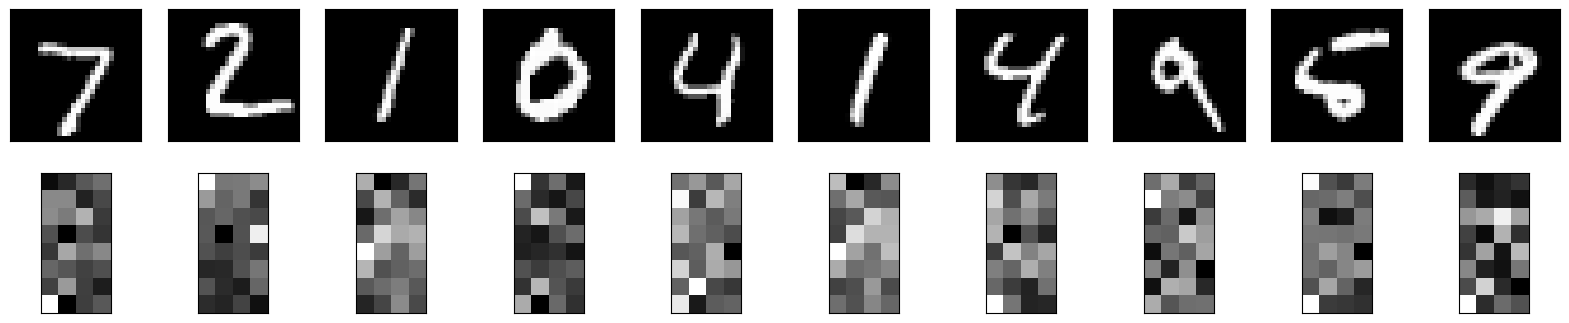

In [50]:
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the architecture of the autoencoder
input_size = 784  # 28x28 pixels
encoding_dim = 32  # Size of the encoded representation

input_img = Input(shape=(input_size,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_size, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Extract the encoder model
encoder_model = Model(input_img, encoded)

# Encode some digits from the test set
encoded_imgs = encoder_model.predict(x_test)

# Display original and encoded images
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display encoded representations
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))  # Displaying the 32-dimensional encoding as a 8x4 image
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
